# 05 EfficientNet and Custom Pretrained Models

This notebook will cover:
* Using a `PyTorch` model
* Using pre-trained weights for transfer learning
* Setting up a `cnn_learner` style `Learner`

## The Problem:

The problem today will be a familiar one, `PETs`, as we are going to focus on the `Learner` instead

In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress fastai2 fastcore --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade
os._exit(00)

In [0]:
from fastai2.vision.all import *

Let's make our usual dataloaders real quick

In [0]:
path = untar_data(URLs.PETS)/'images'
fnames = get_image_files(path)
pat = r'/([^/]+)_\d+.*'

In [0]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [0]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [0]:
dls = pets.dataloaders(path, bs=bs)

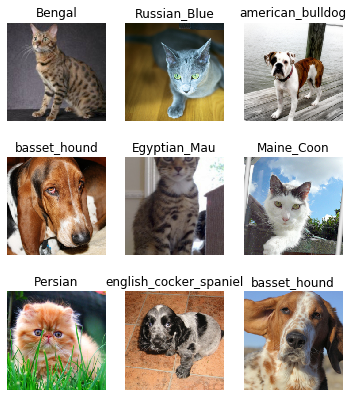

In [13]:
dls.show_batch(max_n=9, figsize=(6,7))

Now let's focus on our `EfficentNet` model. We'll be working out of Ross Wightman's repository [here](https://github.com/rwightman/pytorch-image-models). Included in this repository is tons of pretrained models for almost every major model in Computer Vision. All were for 224x224 training and validation size. Let's install it

In [14]:
!pip install timm

     |████████████████████████████████| 143kB 4.6MB/s 


Now we can then use his weights one of two ways. First we'll show the direct way to load it in, then we'll load in the weights ourselves

In [0]:
from timm import create_model

In [16]:
net = create_model('efficientnet_b3a', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth


Now let's take a look at our downloaded model, so we know how to modify it for transfer learning. With fastai models we can do something like so:

In [18]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]


In [19]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

And we see this head of our model! Let's see if we can do this for our `EfficientNet`

In [20]:
net[-1]

TypeError: ignored

No! Why?

In [22]:
len(learn.model)

2

In [23]:
len(net)

TypeError: ignored

We can see that our `fastai2` model was **split** into two different layer groups:

* Group 1: Our encoder, which is everything but the last layer of our original model
* Group 2: Our head, which is a `fastai2` version of a `Linear` layer plus a few extra bits

In [24]:
create_head(2048, 10)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

How do we do this for our model? Let's take a look at it:

In [25]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Swish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )

We can see that our `Pooling` layer and our `Linear` layer is the last two layers of our model. Let's pop those off

Now if we use the original `fastai2` `create_body` function, we'll get an error:

In [29]:
body = create_body(net, pretrained=False, cut=-1)

TypeError: ignored

Why? Let's take a look

In [0]:
def create_body(arch, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

We can see that arch needs to be a **generator**. Let's try to make a function to help us with specifically his library

In [0]:
def create_timm_body(arch:str, pretrained=True, cut=None):
  model = create_model(arch, pretrained=pretrained)
  if cut is None:
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
  if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
  elif callable(cut): return cut(model)
  else: raise NamedError("cut must be either integer or function")

Let's try it out!

In [0]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [34]:
len(body)

7

Now we can see that we have seven seperate splits

In [36]:
body

Sequential(
  (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Swish()
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): Depthwis

But we've popped off the last layers we need! Let's move onto our head of the model. We know the input should be `3072` (we can see this in the last linear layer of the original model). We need it 2x it because of our `AdaptiveConcatPooling` We want it to have an output to our classes. But what if we dont' know that?

In [9]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); nf

3072

In [0]:
head = create_head(nf, dls.c)

In [54]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3072, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

Now finally we need to wrap it together

In [0]:
model = nn.Sequential(body, head)

And then we initialize our new head of our model

In [0]:
apply_init(model[1], nn.init.kaiming_normal_)

Now we have our two layer-long model! What's next?

In [71]:
len(model)

2

Let's try making a `Learner`

In [0]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())

In [59]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 40 x 112 x 112  1,080      True      
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 40 x 112 x 112  360        True      
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
AdaptiveAvgPool2d    64 x 40 x 1 x 1      0          False     
_________________________________________________

Oh no! It isn't frozen, what do we do? We never split the model! Since we have it set to where `model[0]` is the first group and `model[1]` is the second group, we can use the `default_split` splitter. Let's try again

In [0]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)

In [14]:
learn.freeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 40 x 112 x 112  1,080      False     
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 40 x 112 x 112  360        False     
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
AdaptiveAvgPool2d    64 x 40 x 1 x 1      0          False     
_________________________________________________

That looks much better. Let's train!

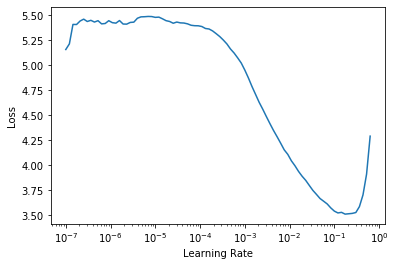

In [65]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, slice(3e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.700641,1.801064,0.770636,01:16
1,1.277738,1.027878,0.895805,01:16
2,1.046595,0.974152,0.914750,01:15
3,0.935457,0.929803,0.916779,01:16
4,0.870509,0.899026,0.932341,01:16


In [0]:
learn.save('stage_1')

Then we can unfreeze it and train a little more

## TODO: Unfreeze and train

## TODO: Use pretrained pkl file (transfer learn twice)